Many members of our community focus on developing numerical models to study how landscapes evolve over time. The simplest and most commonly used transport law used to capture the evolution of hillslopes is a diffusion equation:

$$\frac{\partial z}{\partial t} = K \; \frac{\partial^2 z}{\partial x^2}$$

where $z$ is elevation, $x$ is the horizontal distance, and $K$ is a landscape diffusion coefficient.

## Finite difference methods

We can solve partial differential equations using finite difference methods by replacing the spatial and time derivatives with approximations that use the gridded data. $xx$ is the index along an array of x positions and $tt$ is the timestep.

The time derivative $\partial z/\partial t$ can be approximated using a forward difference:

$$\frac{\partial z}{\partial t} \approx \frac{z_{xx, \; tt+1} - z_{xx, \; tt}}{d t}$$

The second spatial derivative $\frac{\partial^2 z}{\partial x^2}$ can be approximated by combining a forward and a backwards difference:

$$\frac{\partial^2 z}{\partial x^2} \approx \frac{z_{xx+1, \; tt} - 2 z_{xx, \; tt} + z_{xx-1, \; tt}}{(d x)^2}$$

The diffusion equation can then be rewritten as:

$$\frac{z_{xx, \; tt+1} - z_{xx, \; tt}}{d t} = K \;  \frac{z_{xx+1, \; tt} - 2 z_{xx, \; tt} + z_{xx-1, \; tt}}{(d x)^2}$$

We can rearrange this equation to solve for the elevation $z$ at position $x$ at timestep $t+1$:

$$z_{xx, \; tt+1} = z_{xx, \; tt} + K \; d t \; \frac{z_{xx+1, \; tt} - 2 z_{xx, \; tt} + z_{xx-1, \; tt}}{(d x)^2}$$

Essentially, the elevation of a point at any timestep depends on the elevation of that point and its two neighbors at the previous timestep

[[[[[[[[[[[[[[[[[[[[add fig here]]]]]]]]]]]]]]]]]]]]]

## Diffusion in 1D

Let's start by simulating the evolution of a 1D profile across our dataset due to diffusion. First, we need to extract a profile across the DEM:

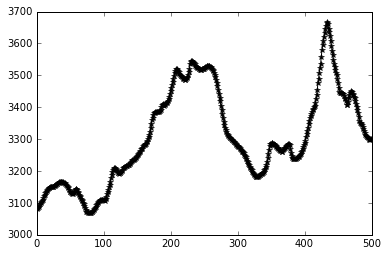

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

topo = np.loadtxt('data/topo.asc', delimiter=',')

profile = topo[:,120]

plt.plot(profile, 'k*-')

This is the topography at time $t = 0$. For every point in the array, the topography at time $t = dt$ is going to be given by the equation above.

Let's create a new NumPy array of the same shape as the profile where we can store the values of the new elevation values. The NumPy function `zeros_like()` creates an array of the same shape where every entry is zero:





Let's now model the evolution of this profile due to diffusion.




We will follow this algorithm:

* loop through time ($\; d t \;$)
    * step through the profile ($\; d x \;$)
        * calculate $z_{x, \; t+1}$
        
At every timestep, we will use the elevations at time $t$ to calculate the elevations at time $t+1$. We need to create a new array of the same size as the old profile to store the values of the new profile. We will also create a new variable to keep track of the old profile. Because NumPy arrays are mutable objects, we need to make a copy of the profile object.

In [3]:
newProfile = np.zeros_like(profile)

print profile.shape, profile.max()
print newProfile.shape, newProfile.max()

(500,) 3668.7078
(500,) 0.0


The new value of any one point using the finite difference diffusion equation depends on the values of that point and its two neighbors, so we have to decide what to do about the first and last cells in the profile, since they only have one neighbor. The simplest solution is to keep their elevation fixed and not let them evolve:

In [4]:
newProfile[0] = profile[0]
newProfile[-1] = profile[-1]

We can now use the finite difference diffusion equation to calculate the elevation of the interior cells of the profile after one timestep.

For the cell with index 1, we can write the equation as:

In [5]:
K = 1
dt = 1
dx = 2 #meters

newProfile[1] = profile[1] + K * dt * (profile[2] - 2 * profile[1] + profile[0]) / dx**2

print profile[0:3]
print newProfile[0:3]

[ 3080.0466  3082.6816  3085.4751]
[ 3080.0466    3082.721225     0.      ]


We chose dummy values for $K$ and $dt$. The value of $dx$ is the cell spacing in the original topo raster.

The equation for the elevation of the cell with index 2 is very similar:

In [6]:
newProfile[2] = profile[2] + K * dt * (profile[3] - 2 * profile[2] + profile[1]) / dx**2

print profile[0:3]
print newProfile[0:3]

[ 3080.0466  3082.6816  3085.4751]
[ 3080.0466    3082.721225  3085.565775]


We could keep doing this for every single cell in the array, but it would get boring very quickly! The code would also not scale very well, since we wouldn't be able to use it for longer or shorter profiles. It would also be very fragile, since it's likely that we would accidentally introduce an error into the code by mistyping something.

## For loops

Automating repetitive tasks is best accomplished with a loop. A For Loop repeats a set of actions for every item in a collection (every letter in a word, every number in some range, every name in a list) until it runs out of items:

In [13]:
word = 'lead'
for char in word:
    print char

l
e
a
d


This is shorter than writing individual statements for printing every letter in the word and it easy scales to longer or shorter words:

In [16]:
word = 'aluminium'
for char in word:
    print char

a
l
u
m
i
n
i
u
m


In [15]:
word = 'tin'
for char in word:
    print char

t
i
n


The general form of a for loop is:

In [ ]:
for item in collection:
    do things with item

A for loop starts with the word "for", then the variable name that each item in the collection is going to take inside the loop, then the word "in", and then the collection or sequence of items to loop through.

In Python, there must be a colon at the end of the line starting the loop. The commands that are run repeatedly inside the loop are indented below that. Unlike many other languages, there is no command to end a loop (e.g. `end for`): the loop ends once the indentation moves back.

In [17]:
length = 0
word = 'elephant'
for letter in word:
    length = length + 1
print 'There are', length, 'letters in', word

There are 8 letters in elephant


It’s worth tracing the execution of this little program step by step. Since there are eight characters in ‘elephant’, the statement inside the loop will be executed eight times. The first time around, `length` is zero (the value assigned to it on line 1) and `letter` is "e". The code adds 1 to the old value of `length`, producing 1, and updates `length` to refer to that new value. The next time the loop starts, `letter` is "l" and `length` is 1, so `length` is updated to 2. Once there are no characters left in "elephant" for Python to assign to `letter`, the loop finishes and the `print` statement tells us the final value of length.

Note that a loop variable is just a variable that’s being used to record progress in a loop. It still exists after the loop is over (and has the last value it had inside the loop). We can re-use variables previously defined as loop variables, overwriting their value:

In [19]:
letter = 'z'
for letter in 'abc':
    print letter
print 'after the loop, letter is', letter

a
b
c
after the loop, letter is c


# add callout and exercises from 03-loops

## Looping through the profile

Instead of writing the same equation for each cell in the profile, let's intead use a for loop that runs the equation for each of the interior cells.

## From 0 to N-1 {.callout}

Python has a built-in function called `range` for creating a sequence of integers. `range` can accept 1-3 parameters. If it gets one parameter as input, `range` creates a list of that length starting at zero and incrementing by 1. If it gets 2 parameters as input, `range` starts at the first and ends at the second, incrementing by one. If `range` is passed 3 parameters, it stars at the first one, ends at the second one, and increments by the third one. For example, `range(3)` produces a list with the numbers 0, 1, 2, `range(2, 5)` produces 2, 3, 4, and `range(3, 10, 3)` produces 3, 6, 9.

We can write a for loop that calls each of the cells of the profile by their index. Since we are fixing the elevation of the first and last cell, our loop should apply the equation for cells with indices 1 through `len(profile)-1`:

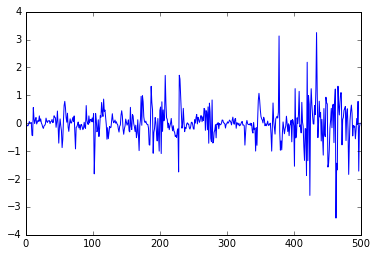

In [15]:
for i in range(1,len(profile)-1):
    newProfile[i] = profile[i] + K * dt * (profile[i+1] - 2 * profile[i] + profile[i-1]) / dx**2
    
plt.plot(profile - newProfile)

We can now put together a script that will evolve the profile by one timestep:

In [16]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

topo = np.loadtxt('data/topo.asc', delimiter=',')
profile = topo[:,120]

K = 1
dt = 1
dx = 2 #meters

newProfile = np.zeros_like(profile)

newProfile[0] = profile[0]
newProfile[-1] = profile[-1]

for i in range(1,len(profile)-1):
    newProfile[i] = profile[i] + K * dt * (profile[i+1] - 2 * profile[i] + profile[i-1]) / dx**2

## Vectorized math is faster! {.callout}

Python, like Matlab, will (usually!) do math in numerical arrays much faster if the code is vectorized than using loops. You should avoid loops when doing math to make your code as efficient as possible -- our script is a very bad example!

One timestep is not enough time for the topographic profile to evolve much. We could increase the value of `dt`, but we can't change it much before the code becomes numerically unstable. Instead, we want to run our code repeatedly so the profile can change gradually. We can wrap it all in another for loop that steps through time:

In [17]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

topo = np.loadtxt('data/topo.asc', delimiter=',')
profile = topo[:,120]

K = 1
dt = 1
dx = 2 #meters

maxt = 10

for t in range(0,maxt,dt):

    newProfile = np.zeros_like(profile)

    newProfile[0] = profile[0]
    newProfile[-1] = profile[-1]

    for i in range(1,len(profile)-1):
        newProfile[i] = profile[i] + K * dt * (profile[i+1] - 2 * profile[i] + profile[i-1]) / dx**2

There is a problem with this script: the time loop is always calculating the evolution of the original topography, not the new profile! We need to rewrite our script so the "new" profile becomes the "old" profile before running the loop again. Because NumPy arrays are immutable objects, we need to make a true copy of the new profile instead of just using the equal sign. Let's also add a plotting function so we can see how the profile changes over time:

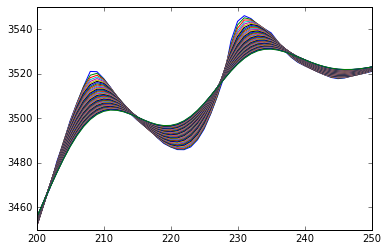

In [22]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

topo = np.loadtxt('data/topo.asc', delimiter=',')
profile = topo[:,120]

K = 1
dt = 1
dx = 2 #meters

maxt = 50

plt.plot(profile, hold=True)

for t in range(0,maxt,dt):

    newProfile = np.zeros_like(profile)

    newProfile[0] = profile[0]
    newProfile[-1] = profile[-1]

    for i in range(1,len(profile)-1):
        newProfile[i] = profile[i] + K * dt * (profile[i+1] - 2 * profile[i] + profile[i-1]) / dx**2
        
    profile = newProfile.copy()
    
    plt.plot(profile)
    plt.xlim((200,250))
    plt.ylim((3450,3550))
    

## Numerical instabilities {.challenge}

Consider three cells somewhere in the profile where the middle cell is the lowest. Using the diffusion equation, we can see that the two outer cells would be dropping in elevation and the middle one would be moving up. What might the profile look like after one timestep if the value of `dt` is very (very!) large? (Hint: Stop thinking of the real world and look at the equation. What does `dt` do to each term?)

We can see that the topographic profile is evolving if we zoom into the plot but, because we are plotting every time we go around the time loop, there are too many lines and they are too close together to differentiate between them. Instead, let's only run the plotting commands every 10 timesteps.

There are several ways we can detect when 10 timesteps have passed:

* Add a counter that increases by 1 every time the time loop runs. When the counter is equal to 10, the counter resets to 0.

* The value of the loop variable `t` will be divisible by `10*dt` every 10 timesteps. The Modulus operator `%` divides two numbers and returns the remainder, so the operation `t%(10*dt)` will be equal to zero every 10 timesteps.


## Making Choices

When analyzing data, we’ll often want to automatically recognize differences between values and take different actions on the data depending on some conditions. Here, we’ll learn how to write code that runs only when certain conditions are true.

### Conditionals
We can ask Python to running different commands depending on a condition with an if statement:

In [23]:
num = 42

if num > 100:
    print 'greater'
else:
    print 'not greater'
    
print 'done'

not greater
done


The second line of this code uses the keyword `if` to tell Python that we want to make a choice. If the test that follows the `if` statement is true, the commands in the indented block are executed. If the test is false, the indented block beneath the else is executed instead. Only one or the other is ever executed.

Conditional statements don’t have to include an `else`. If there isn’t one, Python simply does nothing if the test is false:

In [24]:
num = 42
print 'before conditional...'
if num > 100:
    print num, 'is greater than 100'
print '...after conditional'

before conditional...
...after conditional


We can also chain several tests together using `elif`, which is short for “else if”. The following Python code uses elif to print the sign of a number. We use a double equals sign `==` to test for equality between two values. The single equal sign is used for assignment:

In [25]:
num = -3

if num > 0:
    print num, "is positive"
elif num == 0:
    print num, "is zero"
else:
    print num, "is negative"

-3 is negative


We can also combine tests using `and` and `or`. `and` is only true if both parts are true:

In [26]:
if (1 > 0) and (-1 > 0):
    print 'both tests are true'
else:
    print 'at least one test is false'

at least one test is false


while `or` is true if at least one part is true:

In [27]:
if (1 > 0) or (-1 > 0):
    print 'at least one test is true'
else:
    print 'neither test is true'

at least one test is true


## add challenges from conditionals

Let's add a counter to our script so a line is added to the plot only once every 10 timesteps:

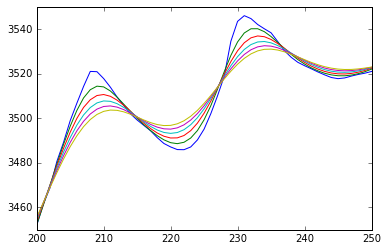

In [31]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

topo = np.loadtxt('data/topo.asc', delimiter=',')
profile = topo[:,120]

K = 1
dt = 1
dx = 2 #meters

maxt = 50
counter = 0

plt.plot(profile, hold=True)

for t in range(0,maxt,dt):

    newProfile = np.zeros_like(profile)

    newProfile[0] = profile[0]
    newProfile[-1] = profile[-1]

    for i in range(1,len(profile)-1):
        newProfile[i] = profile[i] + K * dt * (profile[i+1] - 2 * profile[i] + profile[i-1]) / dx**2
        
    profile = newProfile.copy()
    
    counter = counter + 1
    
    if counter == 10:
        
        counter = 0
    
        plt.plot(profile)
        plt.xlim((200,250))
        plt.ylim((3450,3550))
    